# Molecule Type Distribution Plot

This notebook generates visualizations showing the distribution of different molecule types (Peptide, Nanobody, ScFV, Unidentified) across EGFR competition rounds.

## Reproducibility Note
This notebook sets all relevant random seeds to ensure reproducible results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print(f"Random seed set to: {RANDOM_SEED}")

Random seed set to: 42


In [2]:
import sys
import os

# Add the repo's scripts directory to Python path for theme import
theme_path = os.path.abspath('../adaptyv/adaptyv_analyses/scripts/plotting_python')
if theme_path not in sys.path:
    sys.path.insert(0, theme_path)

# Import the Adaptyv theme from the repo
import blog_post_theme as adaptyv_theme

# Apply the theme (sets matplotlib rcParams, which seaborn respects)
adaptyv_theme.set_adaptyv_matplotlib_theme()

# Get color palettes
palettes = adaptyv_theme.get_adaptyv_palettes()

print(f"Theme loaded from repo: {theme_path}")
print("Note: Adaptyv theme applied to matplotlib (seaborn will inherit these settings)")

Theme loaded from repo: /Users/qamar/Downloads/adaptyv_nature_paper/egfr2024_post_competition/adaptyv/adaptyv_analyses/scripts/plotting_python
Note: Adaptyv theme applied to matplotlib (seaborn will inherit these settings)


## Load and Prepare Data

In [3]:
import json

# Load the data from parquet file
df = pd.read_parquet("data/unioned_egfr_features.parquet")

print(f"Loaded {len(df)} rows from data/unioned_egfr_features.parquet")

Loaded 733 rows from data/unioned_egfr_features.parquet


In [4]:
def expand_feature_column(df: pd.DataFrame, feature_col: str = "feature") -> pd.DataFrame:
    """
    Expands a column containing dictionaries into separate columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    feature_col (str): The name of the column containing dictionaries.
    
    Returns:
    pd.DataFrame: A new DataFrame with the expanded features as separate columns.
    """
    df = df.copy()
    df[feature_col] = df[feature_col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    
    # Normalize and expand the feature column
    features_df = df[feature_col].apply(pd.Series)
    
    # Concatenate with the original DataFrame
    df = pd.concat([df.drop(columns=[feature_col]), features_df], axis=1)
    
    return df

In [5]:
# Expand alphapulldown features
df_pulldown = expand_feature_column(df, feature_col='alphapulldown_feature')

print(f"Expanded to {len(df_pulldown.columns)} columns")

Expanded to 54 columns


## Prepare Data for Visualization

In [6]:
# Filter out pacesa source and create categorical columns
df = df_pulldown[df_pulldown["source"] != 'pacesa']

# Create Source labels
df.loc[(df["source"].str.startswith("adaptyv")), "Source"] = "EGFR Competition"
df.loc[df["source"] == "biolm", "Source"] = "BioLM R1"
df.loc[df["source"] == "silica", "Source"] = "Bio x ML Team Silica"

# Create Data Source labels
df.loc[(df["source"] == "adaptyv-round-1"), "Data Source"] = "EGFR Competition R1"
df.loc[(df["source"] == "adaptyv-round-2"), "Data Source"] = "EGFR Competition R2"
df.loc[df["source"] == "biolm", "Data Source"] = "BioLM R1"
df.loc[df["source"] == "silica", "Data Source"] = "Bio x ML Team Silica"

# Create Control and Binding labels
df.loc[df["is_control"] == True, "Control"] = "Control"
df.loc[df["is_control"] != True, "Control"] = "Not Control"
df.loc[df["binding"] == True, "Binding"] = "True"
df.loc[df["binding"] == False, "Binding"] = "False"

ref_seqs = df[df["is_control"] == True].sequence.unique().tolist()

In [7]:
# Create Design Method categories
df.loc[(df.model_category.str.contains("proteinmpnn", na=False)), "Design Method"] = "MPNN"
df.loc[(df.model_category.str.contains("Evodiff", na=False)), "Design Method"] = "EvoDiff"
df.loc[df.model_category.str.contains("Md + docking", na=False), "Design Method"] = "Rosetta/Rational/Physics Informed"
df.loc[df.model_category.str.contains("Rational design", na=False), "Design Method"] = "Rosetta/Rational/Physics Informed"
df.loc[df.model_category.str.contains("Rosetta", na=False), "Design Method"] = "Rosetta/Rational/Physics Informed"
df.loc[df.model_category.str.contains("Rfdiffusion", na=False), "Design Method"] = "RFDiffusion"
df.loc[df.model_category.str.contains("Alphafold2", na=False), "Design Method"] = "Alphafold2/Bindcraft/RSO"
df.loc[df.model_category.str.contains("Bindcraft/rso", na=False), "Design Method"] = "Alphafold2/Bindcraft/RSO"
df.loc[df.model_category.str.contains("Esm2", na=False), "Design Method"] = "ESM2"
df.loc[df.model_category.str.contains("esm2", na=False), "Design Method"] = "ESM2"
df.loc[df.model_category.str.contains("Timed", na=False), "Design Method"] = "Timed"
df.loc[df.model_category.str.contains("mlde", na=False), "Design Method"] = "MLDE"
df.loc[df.model_category.str.contains("evoprotgrad", na=False), "Design Method"] = "EvoProtGrad"

## Molecule Type Classification

In [8]:
# Standardize molecule type labels
df["Molecule Type"] = df["molecule_type"]
# Note: "Polypeptide" is left as-is in this visualization (not renamed to "Unidentified")

print("Molecule Type distribution:")
print(df["Molecule Type"].value_counts())

Molecule Type distribution:
Molecule Type
Peptide         221
Nanobody        212
Unidentified    118
Polypeptide     116
ScFV             66
Name: count, dtype: int64


## Filter Data for Visualization

In [9]:
# Filter for non-control sequences and exclude BioLM R1
df_filtered = df[df["is_control"] != True]
df_filtered = df_filtered[df_filtered["Data Source"] != "BioLM R1"]

print(f"Filtered data: {len(df_filtered)} rows")
print(f"Data sources in filtered data: {df_filtered['Data Source'].unique()}")

Filtered data: 693 rows
Data sources in filtered data: ['EGFR Competition R2' 'EGFR Competition R1' 'Bio x ML Team Silica']


## Visualization: Stacked Bar Plot

This plot shows the distribution of molecule types across competition rounds using a stacked bar chart with count labels.

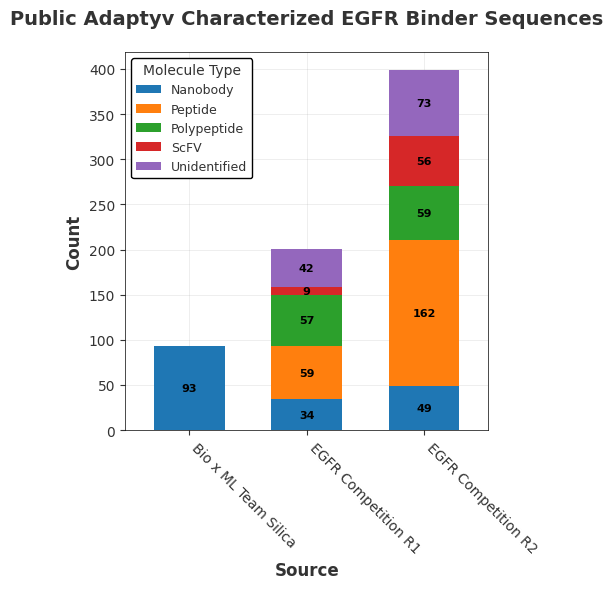

Stacked bar plot: Distribution of molecule types across data sources


In [10]:
# Create counts dataframe for stacked bar plot
counts = df_filtered.groupby(['Data Source', 'Molecule Type']).size().unstack(fill_value=0)

# Create stacked bar plot with adaptyv theme
ax = counts.plot(kind='bar', stacked=True, figsize=(5, 6), width=0.6)

# Add count labels to each segment
for i, (index, row) in enumerate(counts.iterrows()):
    y_offset = 0
    for col in counts.columns:
        height = row[col]
        if height == 0:
            continue  # Don't annotate zero bars

        # Calculate position
        x = i
        y = y_offset + height / 2
        y_offset += height

        # Choose position: inside bar if tall enough, outside if too small
        if height < 5:
            ax.text(x, y_offset + 0.5, str(int(height)), 
                   ha='center', va='bottom', fontsize=8, fontweight='bold')
        else:
            ax.text(x, y, str(int(height)), 
                   ha='center', va='center', color='black', fontsize=8, fontweight='bold')

# Format plot with adaptyv theme styling
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
ax.set_xlabel("Source", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')
ax.set_title("Public Adaptyv Characterized EGFR Binder Sequences", 
            fontsize=14, fontweight='bold', pad=20)
ax.legend(title="Molecule Type", title_fontsize=10, fontsize=9, 
         frameon=True, edgecolor='black', facecolor='white')
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

print("Stacked bar plot: Distribution of molecule types across data sources")

## Alternative Visualization: Side-by-Side Count Plot

This provides an alternative view using seaborn's countplot for comparison.

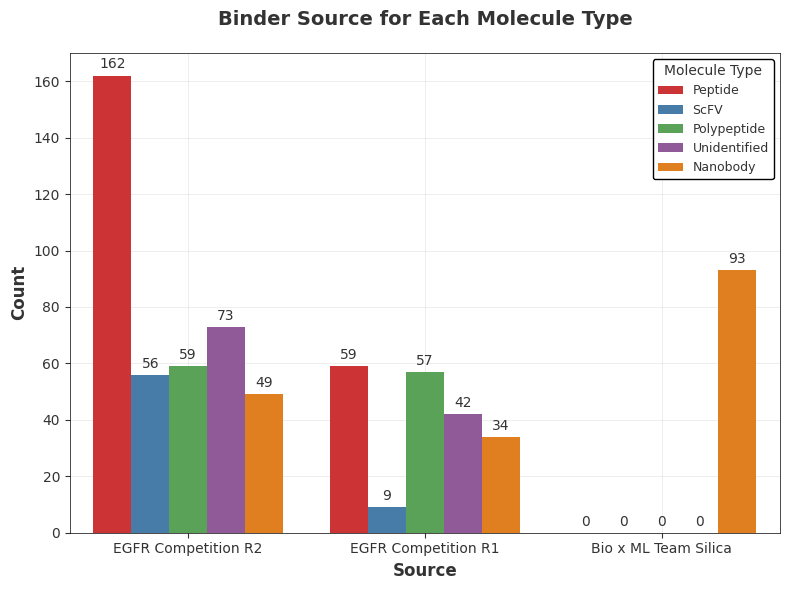

Side-by-side count plot: Molecule types grouped by data source


In [11]:
# Create side-by-side barplot using seaborn
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_filtered, x="Data Source", hue="Molecule Type", palette="Set1")

# Add count annotations
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Labels and styling
ax.set_xlabel("Source", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')
ax.set_title("Binder Source for Each Molecule Type", fontsize=14, fontweight='bold', pad=20)
ax.legend(title="Molecule Type", title_fontsize=10, fontsize=9,
         frameon=True, edgecolor='black', facecolor='white')
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

print("Side-by-side count plot: Molecule types grouped by data source")

## Save Figure (Optional)

Uncomment the cells below to save the figures at publication quality (300 DPI).

Saved: plots/molecule_type_distribution.png


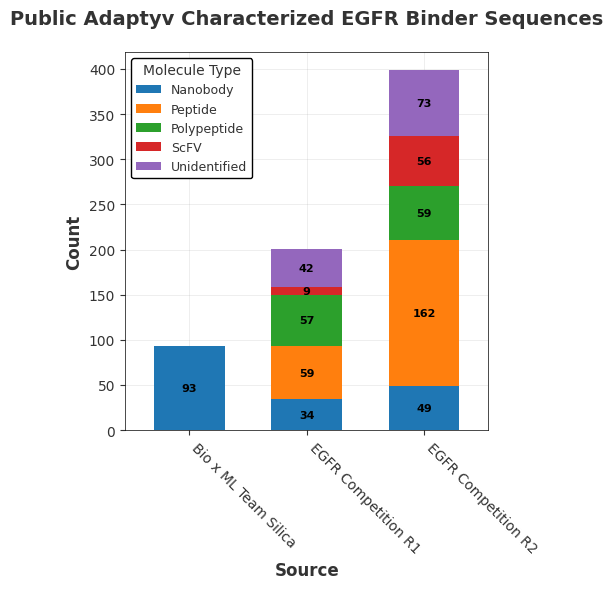

In [12]:
# Save the stacked bar plot
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

counts = df_filtered.groupby(['Data Source', 'Molecule Type']).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(5, 6))
counts.plot(kind='bar', stacked=True, ax=ax, width=0.6)

# Add labels
for i, (index, row) in enumerate(counts.iterrows()):
    y_offset = 0
    for col in counts.columns:
        height = row[col]
        if height == 0:
            continue
        x = i
        y = y_offset + height / 2
        y_offset += height
        if height < 5:
            ax.text(x, y_offset + 0.5, str(int(height)), ha='center', va='bottom', fontsize=8, fontweight='bold')
        else:
            ax.text(x, y, str(int(height)), ha='center', va='center', color='black', fontsize=8, fontweight='bold')

ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
ax.set_xlabel("Source", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')
ax.set_title("Public Adaptyv Characterized EGFR Binder Sequences", fontsize=14, fontweight='bold', pad=20)
ax.legend(title="Molecule Type", title_fontsize=10, fontsize=9,
         frameon=True, edgecolor='black', facecolor='white')
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.set_axisbelow(True)
plt.tight_layout()

output_path = os.path.join(output_dir, "molecule_type_distribution.png")
fig.savefig(output_path, dpi=300, bbox_inches="tight", facecolor='white', edgecolor='none')
print(f"Saved: {output_path}")